# Libererías necesarias

In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
import fasttext
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
from sklearn.decomposition import PCA
import numpy as np
import sys
import umap
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import hdbscan
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap

Primero importamos el dataset que hemos limpiado con la función anteriormente creada

In [2]:
with open("../data/cleaned_data/cleaned_arab_quran.txt", encoding="utf-8") as f:
    lines_ar = f.readlines()

df_ar = pd.DataFrame(lines_ar, columns=["text"])
df_ar["text"] = df_ar["text"].str.strip()

df_ar.head()

,text
0,1|1|بسم الله الرحمن الرحيم
1,1|2|الحمد لله رب العالمين
2,1|3|الرحمن الرحيم
3,1|4|مالك يوم الدين
4,1|5|اياك نعبد واياك نستعين


In [4]:
with open("../data/raw_data/english_quran.txt", "r") as f:
    lines_eng = f.readlines()

df_eng = pd.DataFrame(lines_eng, columns=["text"])
df_eng["text"] = df_eng["text"].str.strip()

df_eng.head()

,text
0,"1|1|In the name of Allah, the Entirely Mercifu..."
1,"1|2|[All] praise is [due] to Allah, Lord of th..."
2,"1|3|The Entirely Merciful, the Especially Merc..."
3,1|4|Sovereign of the Day of Recompense.
4,1|5|It is You we worship and You we ask for help.


# Creación de los modelos

Ahora vamos a usar varios modelos diferentes para comparar los resultados, usaremos el concepto "الجنة" (paraíso) para ambas.

In [4]:
concept = "الجنة"

## Sentence-Transformer Árabe

Importamos el sentence-transformer que vamos a usar para ambos idiomas, ya que éste es multilingüe.

In [ ]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v2', device="cuda")

df_st = pd.DataFrame(lines_ar, columns=["text"])
df_st["text"] = df_st["text"].str.strip()
df_st = df_st[df_st["text"].str.contains(r"[\u0600-\u06FF]")]
df_st["arab_embeddings"] = df_st["text"].apply(lambda x: model.encode(x, convert_to_tensor=True))

concept_emb = model.encode(concept, convert_to_tensor=True)

df_st["cos_similarity"] = df_st["arab_embeddings"].apply(lambda x: util.pytorch_cos_sim(x, concept_emb).item())

df_st_sorted = df_st.sort_values(by="cos_similarity", ascending=False)
print("\nTop 10 Sentence-Transformers:")
print(df_st_sorted[["text", "cos_similarity"]].head(10))

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

In [ ]:
# model.save("../src/modelos/sentence_transformers_arabe_busqueda_semantica")

## FastText Árabe

Ahora probaremos el mismo proceso con el modelo recomendado por nuestro profesor: 'fastText'. Como se verá en los hiperparámetros, las sub palabras hacen referencia a N-gramas de caracteres, es decir, caracteres de entre 3 a 6 letras. (hay que tener en cuenta que a diferencia de sentence-transformer, fast text devuelve vectores Numpy, y no vectores PyTorch)

In [ ]:
ft = fasttext.train_unsupervised(
    input="../data/cleaned_data/cleaned_arab_quran.txt",
    model="skipgram",
    dim=300,
    epoch=10,
    minn=3,  # sub palabras mínimas
    maxn=6   # sub palabras máximas
)

ft.save_model("../src/modelos/fasttext_arabic_busqueda_semantica.bin")

df_ft = pd.DataFrame(lines_ar, columns=["text"])
df_ft["text"] = df_ft["text"].str.strip()
df_ft = df_ft[df_ft["text"].str.contains(r"[\u0600-\u06FF]")]

df_ft["arab_embeddings"] = df_ft["text"].apply(lambda x: ft.get_sentence_vector(x))

concept_emb = ft.get_sentence_vector(concept)

df_ft["cos_similarity"] = df_ft["arab_embeddings"].apply(
    lambda x: cosine_similarity([x], [concept_emb])[0][0]
)

df_ft_sorted = df_ft.sort_values(by="cos_similarity", ascending=False)
print("Top 10 FastText:")
print(df_ft_sorted[["text", "cos_similarity"]].head(10))

Top 10 FastText:
                                                   text  cos_similarity
5815                                 81|16|الجوار الكنس        0.925939
4986               56|8|فاصحاب الميمنه ما اصحاب الميمنه        0.890427
5019                56|41|واصحاب الشمال ما اصحاب الشمال        0.885364
4987               56|9|واصحاب المشامه ما اصحاب المشامه        0.877928
5752                          79|41|فان الجنه هي الماوي        0.854713
3927                    37|140|اذ ابق الي الفلك المشحون        0.854204
5016                                56|38|لاصحاب اليمين        0.848874
3917                           37|130|سلام علي ال ياسين        0.846218
5750                         79|39|فان الجحيم هي الماوي        0.840722
2553  21|71|ونجيناه ولوطا الي الارض التي باركنا فيها...        0.840057


Repetiremos el mismo proceso para el Corán en inglés:

In [6]:
concept = "Paradise" # el mismo que antes, pero ahora en inglés

## Sentence-transformer en inglés

In [ ]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v2', device="cpu")

df_st = pd.DataFrame(lines_eng, columns=["text"])
df_st["text"] = df_st["text"].str.strip()
df_st = df_st[df_st["text"].str.len() > 0]
df_st["eng_embeddings"] = df_st["text"].apply(lambda x: model.encode(x, convert_to_tensor=True))

concept_emb = model.encode(concept, convert_to_tensor=True)

df_st["cos_similarity"] = df_st["eng_embeddings"].apply(lambda x: util.pytorch_cos_sim(x, concept_emb).item())

df_st_sorted = df_st.sort_values(by="cos_similarity", ascending=False)
print("\nTop 10 Sentence-Transformers:")
print(df_st_sorted[["text", "cos_similarity"]].head(10))

model.save("../src/modelos/sentence_transformers_ingles_busqueda_semantica")


Top 10 Sentence-Transformers:
                                                   text  cos_similarity
6022                      89|30|And enter My Paradise."        0.418758
5752  79|41|Then indeed, Paradise will be [his] refuge.        0.413461
1580  11|108|And as for those who were [destined to ...        0.411290
4046  38|77|[Allah] said, "Then get out of Paradise,...        0.382775
5177  62|1|Whatever is in the heavens and whatever i...        0.379114
3494  31|26|To Allah belongs whatever is in the heav...        0.371977
4131  39|74|And they will say, "Praise to Allah, who...        0.371575
2658  22|64|To Him belongs what is in the heavens an...        0.362967
5126  59|1|Whatever is in the heavens and whatever i...        0.361466
4523  46|14|Those are the companions of Paradise, ab...        0.357667


## FastText en inglés

In [7]:
ft = fasttext.train_unsupervised(
    input="../data/cleaned_data/cleaned_english_quran.txt",
    model="skipgram",
    dim=300,
    epoch=10,
    minn=3,  # sub palabras mínimas
    maxn=6   # sub palabras máximas
)

ft.save_model("../src/modelos/fasttext_english_busqueda_seamantica.bin")

df_ft = pd.DataFrame(lines_eng, columns=["text"])
df_ft["text"] = df_ft["text"].str.strip()

df_ft["eng_embeddings"] = df_ft["text"].apply(lambda x: ft.get_sentence_vector(x))

concept_emb = ft.get_sentence_vector(concept)

df_ft["cos_similarity"] = df_ft["eng_embeddings"].apply(
    lambda x: cosine_similarity([x], [concept_emb])[0][0]
)

df_ft_sorted = df_ft.sort_values(by="cos_similarity", ascending=False)
print("Top 10 FastText:")
print(df_ft_sorted[["text", "cos_similarity"]].head(10))

Read 0M words
Number of words:  1917
Number of labels: 0
Progress: 100.0% words/sec/thread:  124179 lr:  0.000000 avg.loss:  2.549972 ETA:   0h 0m 0s


Top 10 FastText:
                                                   text  cos_similarity
428   3|136|Those - their reward is forgiveness from...        0.807003
1323  9|89|Allah has prepared for them gardens benea...        0.805619
2683  23|11|Who will inherit al-Firdaus. They will a...        0.804735
549   4|57|But those who believe and do righteous de...        0.803595
1931  16|31|Gardens of perpetual residence, which th...        0.802792
4019  38|50|Gardens of perpetual residence, whose do...        0.797543
3397  29|58|And those who have believed and done rig...        0.794681
4523  46|14|Those are the companions of Paradise, ab...        0.794010
2617  22|23|Indeed, Allah will admit those who belie...        0.793379
2423  20|76|Gardens of perpetual residence beneath w...        0.790390


# Resultados después de la comparación:
Después de tratar con ambos idiomas y los 2 modelos, y ver que ambos devuelven pasajes similares, concluimos con que hay una diferencia abismal en cuanto a la similitud de coseno. Ya que el modelo 'fastText' obtiene mejores resultados. Por esa razón y por la recomendación del profesor, hemos decidido quedarnos con este modelo para más adelante.

# Visualización de los resultados:
Después de concluir que el modelo 'FastText' rinde mucho mejor para la búsqueda semántica, vamos a visualizar los resultados obtenidos con éste. Para esto, vamos a recolectar los 5 pasajes más similares y los 5 más disimilares del Corán introducido un concepto arbitrario y luego hacer plot 3d para visualizar el espacio de los embeddings. Así podríamos apreciar que los vectores son contrarios en cierta manera. Para esto, utilizaremos PCA para reducir la dimensionalidad para una visualización mejor.

In [ ]:
# Empezaremos en inglés
concepto = "Paradise"
emb_conepto = ft.get_sentence_vector(concepto)

df_ft_nonempty = df_ft[df_ft["text"].notna() & (df_ft["text"].str.strip() != "")]
# Top 5 embeddings más similares
top_5_similares = df_ft.nlargest(5, 'cos_similarity')[["text", "eng_embeddings", "cos_similarity"]]
# Top 5 embeddings más disimilares
top_5_disimilares = df_ft_nonempty.nsmallest(5, 'cos_similarity')[["text", "eng_embeddings", "cos_similarity"]]

top_5_similares["group"] = "Similar"
top_5_disimilares["group"] = "Diferentes"

df_concat = pd.concat([top_5_similares, top_5_disimilares], ignore_index=True)
df_concat = pd.DataFrame(df_concat)

df_concat["textos"] = df_concat["text"].fillna("").astype(str)
df_concat["tooltip"] = df_concat["textos"].apply(lambda x: x if x.strip() != "" else "No hay texto")
embedding_matrix = np.vstack(df_concat["eng_embeddings"].values)

Realizamos PCA para reducir la dimensionalidad y visualizar mejor en 3 dimensiones:

In [ ]:
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embedding_matrix)
df_concat[["x", "y", "z"]] = embeddings_3d

Esta línea es necesaria para evitar problemas de dependencias de librerías:

In [ ]:
import sys
if "narwhals" in sys.modules:
    del sys.modules["narwhals"]

Visualización 3D de los embeddings

In [ ]:
fig = px.scatter_3d(
    df_concat,
    x="x",
    y="y",
    z="z",
    color="group",
    hover_name="textos",  
    size_max=10,
    title=f"Visualización en 3 dimensiones de los 5 embeddings más similares y disimilares del concepto: '{concepto}'"
)

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    legend_title_text='Grupo'
)

fig.show()


Visualización 2D de los embeddings

In [ ]:
textos = df_concat["text"].tolist()
embeddings_2d = df_concat["eng_embeddings"].tolist()

reducer = umap.UMAP(n_neighbors=5) # Número de vecinos = 5 para los 5 más similares y 5 más disimilares
umap_embeddings = reducer.fit_transform(embeddings_2d)

df_umap = pd.DataFrame({"textos": textos,
                        "x": umap_embeddings[:, 0],
                        "y": umap_embeddings[:, 1],
                        "group": df_concat["group"]})

plot_umap = (
    alt.Chart(df_umap).mark_circle(size=100).encode(x="x", y="y", color="group", tooltip=["textos", "group"])
    .properties(title=f"Visualización con UMAP de los 5 embeddings más similares y disimilares a '{concepto}'")
)

plot_umap.interactive()

alt.Chart(...)

Heatmap de los pasajes

Text(0.5, 1.0, "Matriz de similitud de coseno entre los 5 embeddings de los pasajes más similares y disimilares con el concepto: 'Paradise'")

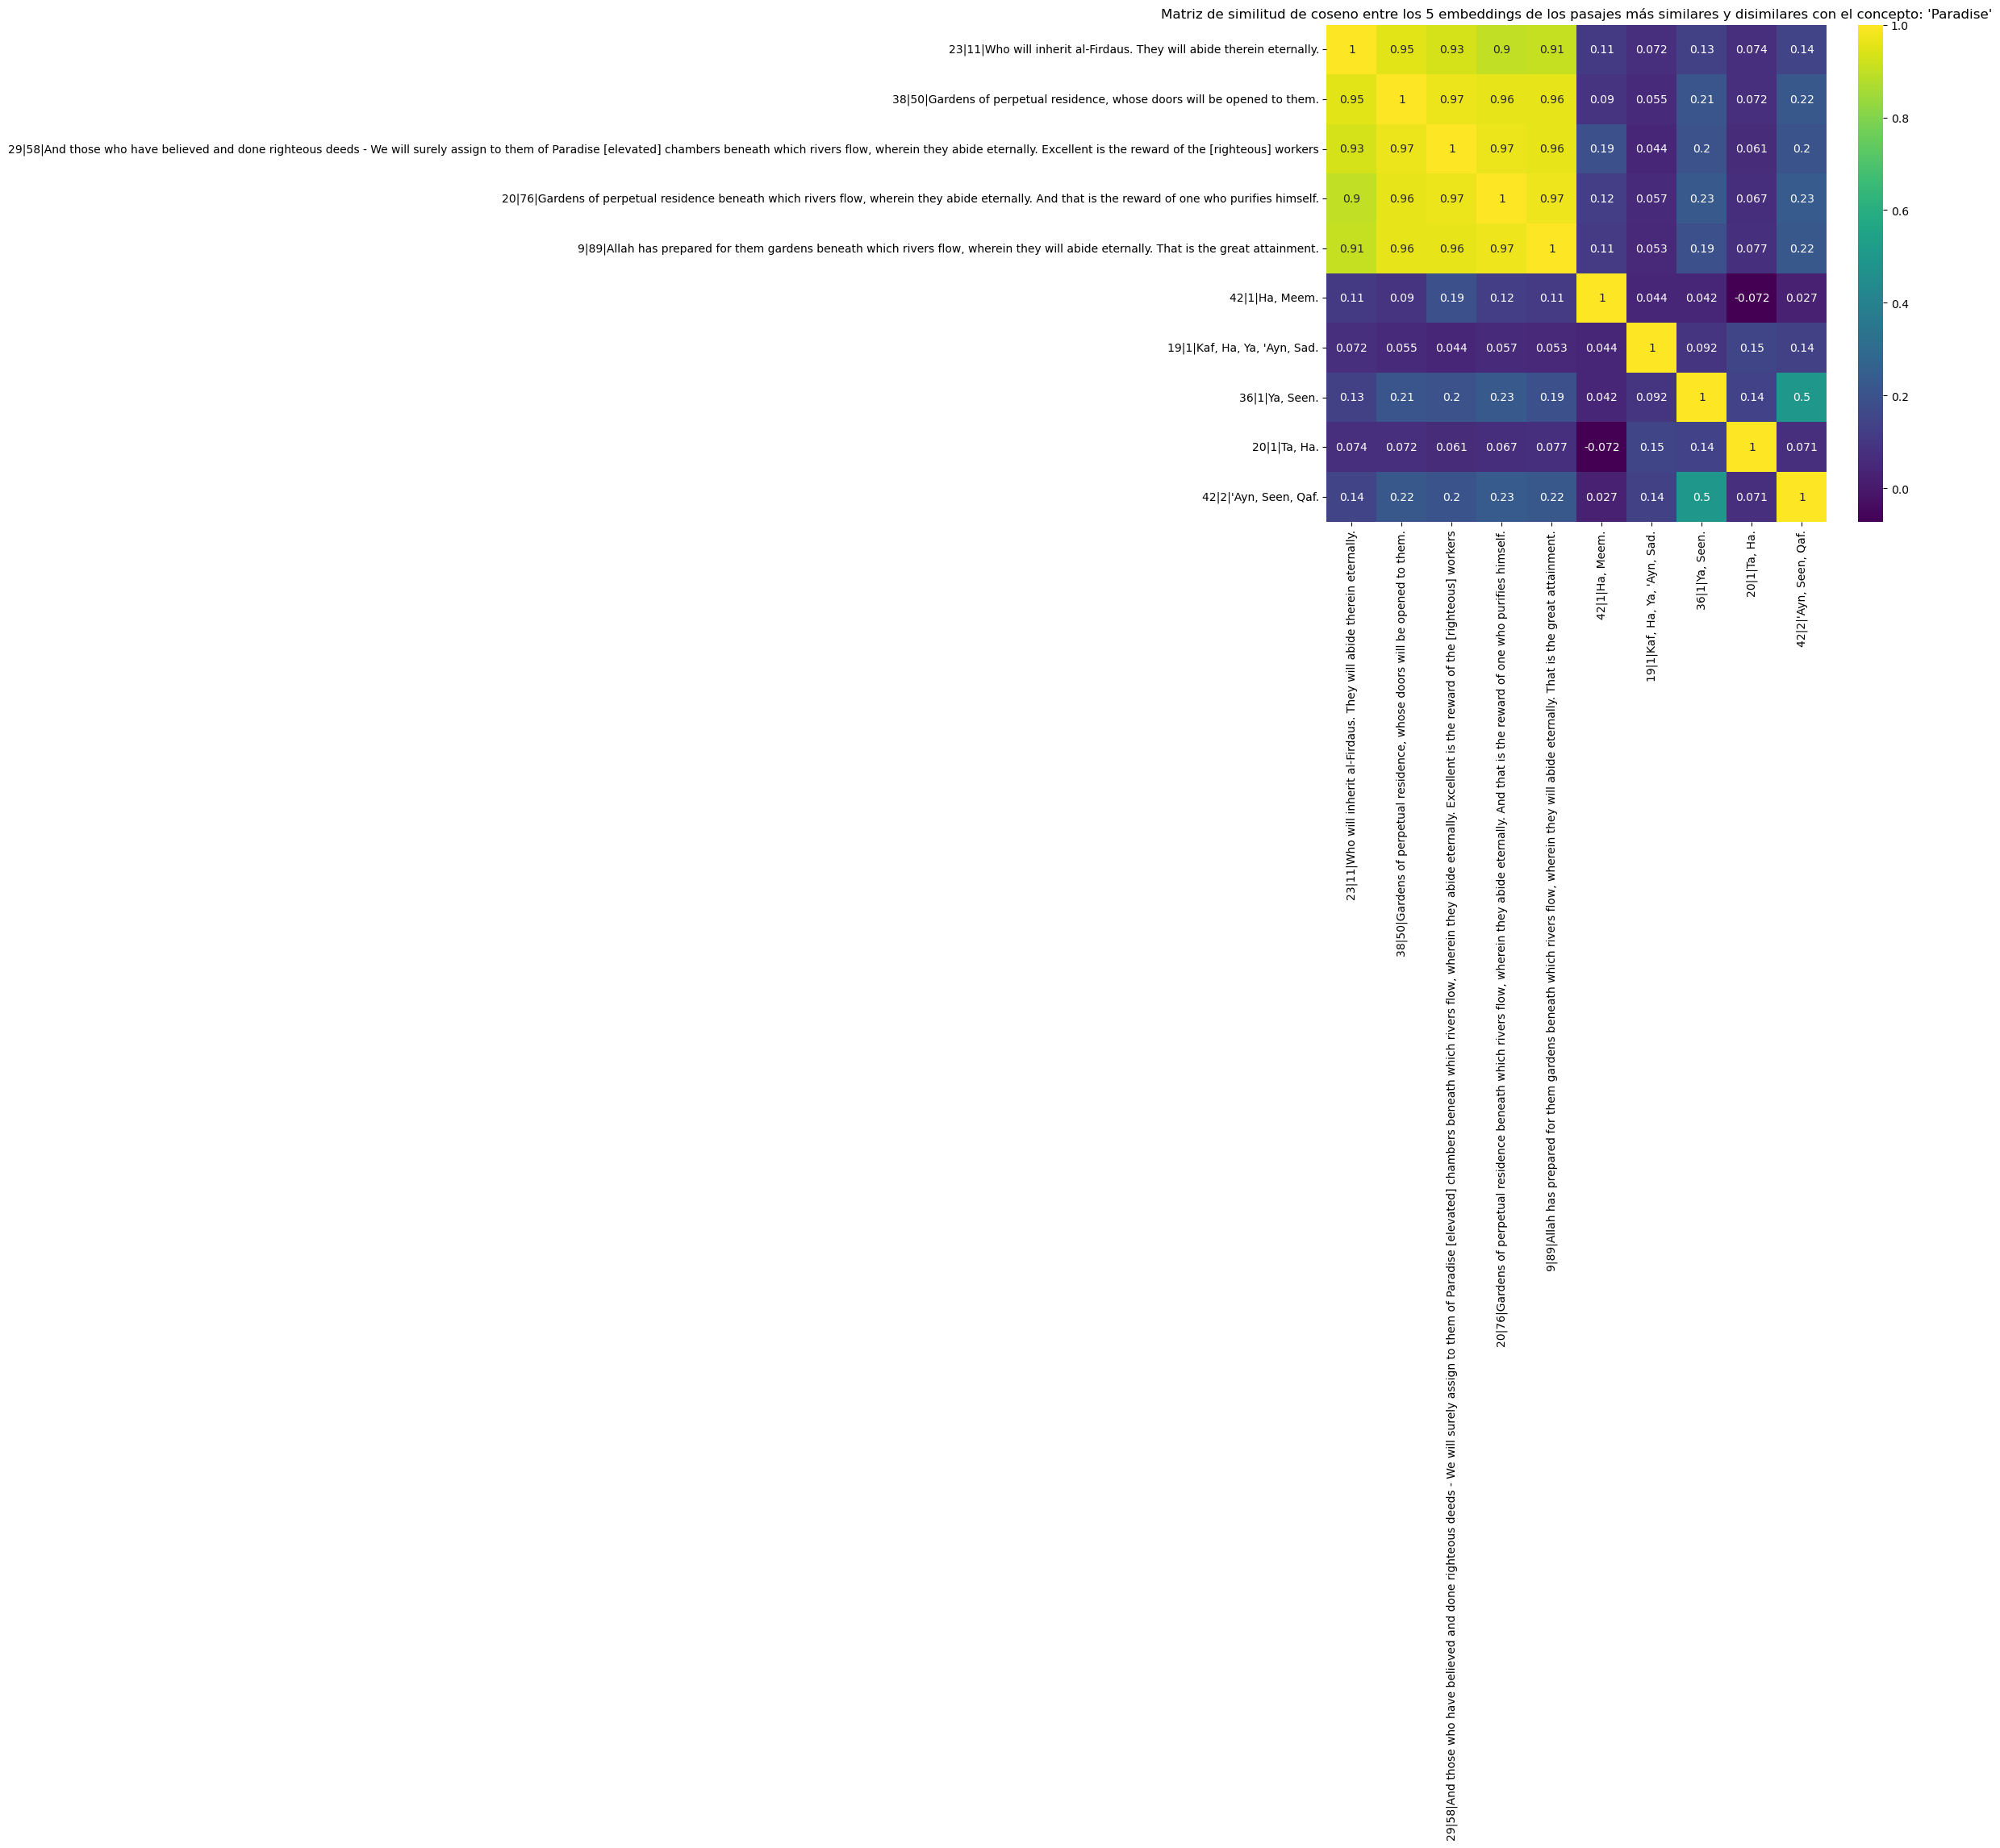

In [ ]:
similarity_matrix = np.vstack(df_concat["eng_embeddings"].values)
similarity_matrix = cosine_similarity(similarity_matrix)
textos = df_concat["text"].tolist()

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=textos, yticklabels=textos, cmap='viridis', annot=True)
plt.title(f"Matriz de similitud de coseno entre los 5 embeddings de los pasajes más similares y disimilares con el concepto: '{concepto}'")